In [1]:
import pandas as pd
import numpy as np
import wbgapi as wb
import yfinance as yf

In [15]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as st
import requests
import scipy.io as sio
import io

from urllib.request import urlopen
from zipfile import ZipFile

from statsmodels.formula.api import ols
from statsmodels.api import add_constant


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA


from scipy.io import loadmat
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

## Atabey's Notes

- Q1: Just code, no analysis. Also, you dropped the NA values. This is a bad idea in general.
- Q2: Same as above.
- Q3: Code is fine. However, no analysis on which variables are important.
- Q4: Your models did not converge as it is apparent in the confusion matrix. You had to solve that problem first.

15 + 15 + 18 + 12

## Q1

In [63]:
countries = ['Spain', 'France', 'Monaco', 'Italy', 'Slovenia', 'Croatia', 'Bosnia and Herzegovina',
             'Montenegro', 'Albania', 'Greece', 'Turkey', 'Syria', 'Lebanon', 'Israel', 'Palestine',
             'Egypt', 'Libya', 'Tunisia', 'Algeria', 'Morocco', 'Malta', 'Cyprus']

attributes = ['SE.ADT.LITR.FE.ZS', 'SL.TLF.ACTI.ZS', 'SP.DYN.IMRT.IN', 'SI.POV.GINI', 'SP.DYN.LE00.IN', 'NY.GDP.PCAP.CD']

countries_coder = wb.economy.coder(countries)
countries_iso = [countries_coder[ct] for ct in countries]

df = wb.data.DataFrame(attributes, countries_iso)

In [64]:
df = raw_data.reset_index()
df_melted = df.melt(id_vars=['economy', 'series'], var_name='year', value_name='value')
df_pivoted = df_melted.pivot_table(index=['economy', 'year'], columns='series', values='value', aggfunc='first').reset_index()

df_pivoted['year'] = df_pivoted['year'].str.replace("YR", "").astype(int)


def lr_log(df, economies, dependent_var='SP.DYN.IMRT.IN'):
    df = df[df['economy'].isin(economies)]
    df = df[df[dependent_var] > 0]
    df[f'Log_{dependent_var}'] = np.log(df[dependent_var])

    X = df.drop(columns=[dependent_var, f'Log_{dependent_var}', 'year', 'economy'])
    X = X.dropna(axis=1, how='all')
    X = X.apply(lambda col: col.fillna(col.mean()), axis=0)

    y = df[f'Log_{dependent_var}']
    X_const = add_constant(X)

    model = sm.OLS(y, X_const).fit()

    summary = model.summary()

    return model, summary


In [66]:
model, summary = lr_log(df_pivoted, economies=['ESP', 'FRA', 'TUR', 'SYR', 'ISR'])
print(summary)

model, summary = lr_log(df_pivoted, economies=['ESP','FRA'])
print(summary)

                            OLS Regression Results                            
Dep. Variable:     Log_SP.DYN.IMRT.IN   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1142.
Date:                Tue, 26 Mar 2024   Prob (F-statistic):          1.28e-194
Time:                        23:54:52   Log-Likelihood:                -14.421
No. Observations:                 310   AIC:                             40.84
Df Residuals:                     304   BIC:                             63.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.8095      0.41

## Q2

In [23]:
tickers = ['SI=F', 'HG=F', 'PL=F', 'GC=F', 'PA=F']

df2 = yf.download(tickers)

df2 = df2.fillna(df2.mean())

df2= df2['Adj Close']
df2

[*********************100%%**********************]  5 of 5 completed


Ticker,GC=F,HG=F,PA=F,PL=F,SI=F
Date,,,,,
2000-01-04,1117.987235,2.71072,441.899994,429.700012,16.629809
2000-01-05,1117.987235,2.71072,438.100006,419.899994,16.629809
2000-01-06,1117.987235,2.71072,435.299988,412.000000,16.629809
2000-01-07,1117.987235,2.71072,443.899994,414.000000,16.629809
2000-01-10,1117.987235,2.71072,451.950012,415.000000,16.629809
...,...,...,...,...,...
2024-03-20,2157.899902,4.03850,994.700012,897.099976,24.933001
2024-03-21,2182.399902,4.04650,1013.400024,910.700012,24.849001
2024-03-22,2158.100098,3.99600,992.799988,896.099976,24.691999


In [24]:
def linear_regression_gold(df):
    X = df2.drop(['GC=F'], axis=1)  
    y = df2['GC=F'] 

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print(model.summary())
    return model

model = linear_regression_gold(df)

                            OLS Regression Results                            
Dep. Variable:                   GC=F   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                 1.195e+04
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:33:20   Log-Likelihood:                -40182.
No. Observations:                6089   AIC:                         8.037e+04
Df Residuals:                    6084   BIC:                         8.041e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        256.8985      8.652     29.692      0.0

In [27]:
def linear_regression_futures(df, ticker):
    X = df2.drop([ticker], axis=1)  
    y = df2[ticker] 

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print(f"Linear Regression Results for {ticker}:")
    print(model.summary())
    return model

tickers = ['SI=F', 'HG=F', 'PL=F', 'PA=F']

for ticker in tickers:
    print("\n")
    linear_regression_futures(df2, ticker)




Linear Regression Results for SI=F:
                            OLS Regression Results                            
Dep. Variable:                   SI=F   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 1.275e+04
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:33:55   Log-Likelihood:                -14624.
No. Observations:                6089   AIC:                         2.926e+04
Df Residuals:                    6084   BIC:                         2.929e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

## Q3

In [12]:
with urlopen('https://www.muratkoklu.com/datasets/vtdhnd07.php') as response:
    content = io.BytesIO(response.read())

with ZipFile(content) as zipfile:
    file_path = 'Acoustic_Extinguisher_Fire_Dataset/Acoustic_Extinguisher_Fire_Dataset.xlsx'
    with zipfile.open(file_path) as file:
        df3 = pd.read_excel(file)

df3

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


In [13]:
df3 = df3[['SIZE','DISTANCE','DESIBEL','AIRFLOW','FREQUENCY','STATUS']]
df3

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,10,96,0.0,75,0
1,1,10,96,0.0,72,1
2,1,10,96,2.6,70,1
3,1,10,96,3.2,68,1
4,1,10,109,4.5,67,1
...,...,...,...,...,...,...
17437,7,190,86,2.2,5,0
17438,7,190,84,2.0,4,0
17439,7,190,80,1.5,3,0
17440,7,190,76,0.4,2,0


In [14]:
X = df3[['SIZE', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY']]
y = df3['STATUS']

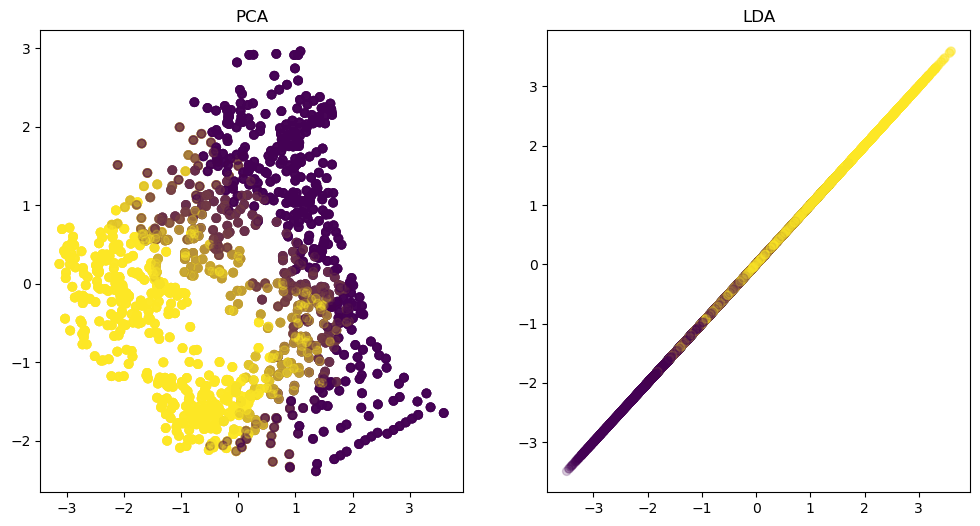

In [15]:
X_std = (X - X.mean()) / X.std()


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)


lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_std, y)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.2)
axs[0].set_title('PCA')

axs[1].scatter(X_lda[:, 0], X_lda[:, 0], c=y, alpha=0.2)
axs[1].set_title('LDA')

plt.show()

### SVM and Logistic Regression Models

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svm_model = SVC(max_iter=1000)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("SVM Outputs:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
                                                    
                                                    
LR_model = LogisticRegression(max_iter=1000)
LR_model.fit(X_train, y_train)

y_pred = LR_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nLogistic Regression Outputs:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)                                                   
                                                    

/Users/bora/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Outputs:
Accuracy: 0.4282029234737747
Precision: 0.44274475524475526
Recall: 0.584535487593768
F1 Score: 0.5038547624968914

Logistic Regression Outputs:
Accuracy: 0.8773287474921181
Precision: 0.8895522388059701
Recall: 0.8597807270628968
F1 Score: 0.874413145539906


When it comes to Logistic Regression, the results consistently hover around 0.80 on average and remain stable. However, for SVM, the results tend to vary more from one run to another compared to LR. While it might yield around 0.50 in one run, it can climb up to the 0.90s in another.

## Q4

In [17]:
response_image = requests.get('https://github.com/kaygun/2024-Spring-388E/raw/main/data/PaviaU.mat')
response_gt = requests.get('https://github.com/kaygun/2024-Spring-388E/raw/main/data/PaviaU_gt.mat')

image = sio.loadmat(io.BytesIO(response_image.content))['paviaU']
gt = sio.loadmat(io.BytesIO(response_gt.content))['paviaU_gt']

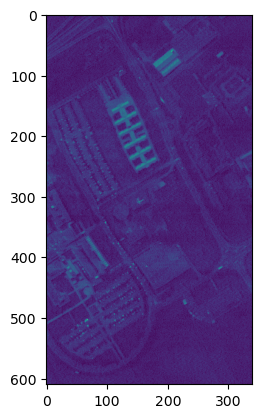

In [5]:
imgplot = plt.imshow(image[:,:,0])

In [18]:
vectors = image.reshape(-1, image.shape[-1])
labels = gt.flatten()

In [19]:
nonzero_indices = np.where(labels != 0)[0]
vectors_filtered = vectors[nonzero_indices]
labels_filtered = labels[nonzero_indices]

In [10]:
def multi_label_LR(vectors, labels, test_size=0.2):
    
    X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=test_size)
    
    model = LogisticRegression(max_iter=1000)  
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    report = classification_report(y_test, y_pred)
    
    return accuracy, report


accuracy, report = multi_label_LR(vectors, labels)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.7956846673095468
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88     33068
           1       0.03      0.00      0.00      1363
           2       0.48      0.18      0.27      3636
           3       0.37      0.13      0.19       448
           4       0.51      0.13      0.21       564
           5       0.74      0.80      0.77       268
           6       0.10      0.01      0.01       966
           7       0.11      0.00      0.01       283
           8       0.00      0.00      0.00       695
           9       0.40      0.10      0.16       189

    accuracy                           0.80     41480
   macro avg       0.36      0.23      0.25     41480
weighted avg       0.71      0.80      0.74     41480



/Users/bora/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
def multi_label_SVM(vectors, labels, test_size=0.2):
    
    X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=test_size)
    
    model = SVC(max_iter=1000)  
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    report = classification_report(y_test, y_pred)
    
    return accuracy, report


accuracy, report = multi_label_SVM(vectors, labels)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

/Users/bora/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.2386692381870781
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.17      0.28     32936
           1       0.17      0.90      0.28      1291
           2       0.16      0.15      0.16      3740
           3       0.21      0.08      0.12       407
           4       0.14      0.89      0.24       607
           5       0.74      0.98      0.84       248
           6       0.06      0.91      0.11      1045
           7       0.44      0.82      0.57       250
           8       0.18      0.96      0.30       768
           9       0.00      0.00      0.00       188

    accuracy                           0.24     41480
   macro avg       0.30      0.59      0.29     41480
weighted avg       0.75      0.24      0.27     41480



/Users/bora/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bora/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bora/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def experiment(X,y, model):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return confusion_matrix(y_test,y_pred)

### Confusion Matrix
#### Logistic Regression

/Users/bora/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


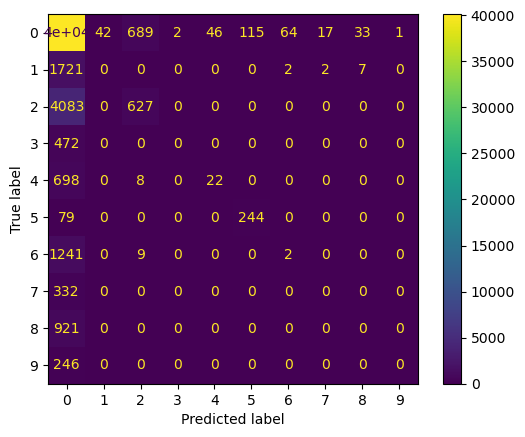

In [13]:
cm = experiment(vectors,labels,LogisticRegression())
ConfusionMatrixDisplay(cm).plot()

#### SVM

In [ ]:
cm = experiment(vectors,labels,SVC())
ConfusionMatrixDisplay(cm).plot()

Could you please run it of SVM? Since it took a long time, I had to get it done by the deadline.

The results given by svm gave worse performance than LR in terms of accuracy.